In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta


import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
data = pd.read_csv('burglaries_preprocessed.csv')
data = data[['Month', 'Ward']]#, 'Season']]

In [3]:
data

,Month,Ward
0,2010-12,High Barnet
1,2010-12,High Barnet
2,2010-12,High Barnet
3,2010-12,High Barnet
4,2010-12,High Barnet
...,...,...
42986,2023-03,Childs Hill
42987,2023-03,Childs Hill
42988,2023-03,Childs Hill
42989,2023-03,Childs Hill


In [4]:
def reg_evaluation(y_test, y_pred, ward: str):    
    print(f'Results for {ward}:')
    print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred),2))
    print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
    print('R2 score:', round(r2_score(y_test, y_pred),2))
    print('Weighted mean absolute percentage error:', 
          round(np.abs(y_test - y_pred).sum() / np.abs(y_test).sum(),2))
    print('\n')

In [5]:
def create_features(df):

    df = df.set_index('Month')
    df.index = pd.to_datetime(df.index)
#     df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['crime_count'] = 1
    
    return df

data = create_features(data)

# look below after adding features

In [6]:
def return_year_month(row):
    return str(row['year']) + '-' + str(row['month'])

In [7]:
data

,Ward,month,year,crime_count
Month,,,,
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
...,...,...,...,...
2023-03-01,Childs Hill,3,2023,1
2023-03-01,Childs Hill,3,2023,1
2023-03-01,Childs Hill,3,2023,1


In [8]:
data_aggr = data.groupby(['year', 'month', 'Ward']).count()
data_aggr.reset_index(inplace=True)


In [9]:
data_aggr.loc[450:500]

,year,month,Ward,crime_count
450,2012,6,Totteridge & Woodside,13
451,2012,6,Underhill,21
452,2012,6,West Finchley,23
453,2012,6,West Hendon,16
454,2012,6,Whetstone,19
455,2012,6,Woodhouse,27
456,2012,7,Barnet Vale,12
457,2012,7,Brunswick Park,10
458,2012,7,Burnt Oak,19
459,2012,7,Childs Hill,26


In [10]:
data_aggr['year_month'] = data_aggr.apply(return_year_month, axis=1)
data_aggr['date'] = data_aggr['year_month']
data_aggr = data_aggr.set_index('date')
data_aggr.index = pd.to_datetime(data_aggr.index)


In [11]:
data_aggr

,year,month,Ward,crime_count,year_month
date,,,,,
2010-12-01,2010,12,Barnet Vale,13,2010-12
2010-12-01,2010,12,Brunswick Park,13,2010-12
2010-12-01,2010,12,Burnt Oak,9,2010-12
2010-12-01,2010,12,Childs Hill,17,2010-12
2010-12-01,2010,12,Colindale North,7,2010-12
...,...,...,...,...,...
2023-03-01,2023,3,Underhill,1,2023-3
2023-03-01,2023,3,West Finchley,13,2023-3
2023-03-01,2023,3,West Hendon,9,2023-3


# IMPUTATION

In [12]:
wards_wo_month = []

for month in data_aggr['Ward'].unique():
    if data_aggr[data_aggr['Ward']==month].shape[0]<148:        
        wards_wo_month.append(month)

In [13]:
all_months = data_aggr.index.unique().to_list()
dct_impute = {}

for ward in wards_wo_month:
    
    lst_months=[]
    
    for i, row in data_aggr[data_aggr['Ward']==ward].iterrows():
        lst_months.append(i)
        dct_impute[ward] = list(set(all_months) - set(lst_months))[0]


In [14]:
dct_impute

{'Colindale North': Timestamp('2014-12-01 00:00:00'),
 'Colindale South': Timestamp('2016-10-01 00:00:00'),
 'Edgwarebury': Timestamp('2021-07-01 00:00:00'),
 'High Barnet': Timestamp('2022-12-01 00:00:00'),
 'Totteridge & Woodside': Timestamp('2021-05-01 00:00:00'),
 'Whetstone': Timestamp('2023-01-01 00:00:00'),
 'Woodhouse': Timestamp('2020-08-01 00:00:00')}

In [15]:
data_aggr.to_csv('data_aggregated.csv')

# fix cell after adding features


In [16]:
data_aggr = data_aggr.append(pd.DataFrame({'year':2014, 'month':12, 'Ward':'Colindale North',# 'Season':'Winter', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Colindale North']['crime_count'].mean()), 
                                           'year_month':'2014-12'}, index=[dct_impute['Colindale North']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2016, 'month':10, 'Ward':'Colindale South',# 'Season':'Autumn', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Colindale South']['crime_count'].mean()), 
                                           'year_month':'2016-10'}, index=[dct_impute['Colindale South']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2021, 'month':7, 'Ward':'Edgwarebury',# 'Season':'Summer', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Edgwarebury']['crime_count'].mean()), 
                                           'year_month':'2021-07'}, index=[dct_impute['Edgwarebury']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2022, 'month':12, 'Ward':'High Barnet',# 'Season':'Winter', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='High Barnet']['crime_count'].mean()), 
                                           'year_month':'2014-12'}, index=[dct_impute['High Barnet']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2021, 'month':5, 'Ward':'Totteridge & Woodside',# 'Season':'Spring', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Totteridge & Woodside']['crime_count'].mean()), 
                                           'year_month':'2021-05'}, index=[dct_impute['Totteridge & Woodside']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2023, 'month':1, 'Ward':'Whetstone',# 'Season':'January', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Whetstone']['crime_count'].mean()), 
                                           'year_month':'2023-01'}, index=[dct_impute['Whetstone']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2020, 'month':8, 'Ward':'Woodhouse',# 'Season':'Summer', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Woodhouse']['crime_count'].mean()), 
                                           'year_month':'2020-08'}, index=[dct_impute['Woodhouse']]))

In [17]:
data_aggr['timestamp']=data_aggr.index
data_aggr.sort_index(inplace=True)

In [50]:
data_aggr.crime_count.mean()

12.120495495495495

# Model 1 - predicting crime rate for 1 ward

In [ ]:
def data_split_1_ward(data, ward, end_train, end_val):
    
    FEATURES = ['month']
    TARGET = 'crime_count'
    
    WARD = ward
    data_1w = data[data['Ward']==WARD]
    
    train_1w = data_1w.loc[data_1w.index < end_train]
    val_1w = data_1w.loc[(data_1w.index >= end_train) & (data_1w.index < end_val)]
    test_1w = data_1w.loc[data_1w.index >= end_val]
    
    X_train_1w = train_1w[FEATURES]
    y_train_1w = train_1w[TARGET]

    X_val_1w = val_1w[FEATURES]
    y_val_1w = val_1w[TARGET]

    X_test_1w = test_1w[FEATURES]
    y_test_1w = test_1w[TARGET]
    
    return X_train_1w, X_val_1w, X_test_1w, y_train_1w, y_val_1w, y_test_1w

In [ ]:
# X_train_1w, X_val_1w, X_test_1w, y_train_1w, y_val_1w, y_test_1w = data_split_1_ward(
#     data_aggr, 'Barnet Vale', '2022-01-01', '2022-08-01')



In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=5000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=10,
                       learning_rate=0.0005)

# reg.fit(X_train_1w, y_train_1w, eval_set=[(X_train_1w, y_train_1w), (X_val_1w, y_val_1w)], verbose=100)


In [ ]:
mae = 0
rmse = 0
r2 = 0
wmape = 0

for ward in data_aggr['Ward'].unique():
    
    X_train_1w, X_val_1w, X_test_1w, y_train_1w, y_val_1w, y_test_1w = data_split_1_ward(
    data_aggr, ward, '2022-01-01', '2022-08-01')

    reg.fit(X_train_1w, y_train_1w, eval_set=[(X_val_1w, y_val_1w)], verbose=200)
    
    reg_evaluation(y_test_1w, reg.predict(X_test_1w), ward)
    
    mae += mean_absolute_error(y_test_1w, reg.predict(X_test_1w))
    rmse += mean_squared_error(y_test_1w, reg.predict(X_test_1w))
    r2 += r2_score(y_test_1w, reg.predict(X_test_1w))
    wmape += np.abs(y_test_1w - reg.predict(X_test_1w)).sum() / np.abs(y_test_1w).sum()
    
mae /= 24
rmse /= 24
rmse = np.sqrt(rmse)
r2 /= 24
wmape /= 24




In [ ]:
print(mae)
print(rmse)
print(wmape)
print(r2)

In [ ]:
# fi = pd.DataFrame(data=reg.feature_importances_,
#              index=reg.feature_names_in_,
#              columns=['importance'])

# fi.sort_values('importance').plot(kind='barh', title='Feature Importances')
# plt.show()

# Model for all wards at once

In [18]:
def wmape(y_true, y_pred):
    '''Weighted Mean Absolute Percentage Error
    '''
    
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [19]:
train = data_aggr.loc[(data_aggr.index >= '2010-03-01') & (data_aggr.index < '2022-03-01')]
#val = data_aggr.loc[(data_aggr.index >= '2022-01-01') & (data_aggr.index < '2022-08-01')]
val = data_aggr.loc[data_aggr.index >= '2022-03-01']

In [20]:
train.drop(columns=['year','timestamp'], inplace=True)

C:\Users\Goshko\anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
train

,month,Ward,crime_count,year_month
2010-12-01,12,Barnet Vale,13,2010-12
2010-12-01,12,Woodhouse,10,2010-12
2010-12-01,12,Whetstone,9,2010-12
2010-12-01,12,West Hendon,13,2010-12
2010-12-01,12,West Finchley,27,2010-12
...,...,...,...,...
2022-02-01,2,Edgware,14,2022-2
2022-02-01,2,Edgwarebury,3,2022-2
2022-02-01,2,Finchley Church End,14,2022-2
2022-02-01,2,Friern Barnet,10,2022-2


In [22]:
train2 = data_aggr.loc[(data_aggr.index >= '2020-03-01') & (data_aggr.index < '2022-03-01')]


## XGBoost with MLforecast

In [23]:
# from mlforecast import MLForecast

# from window_ops.rolling import rolling_mean, rolling_max, rolling_min


# reg2 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
#                        n_estimators=5000,
#                        objective='reg:linear',
#                        max_depth=10,
#                        learning_rate=0.0005)
# # models = [reg2]

# model = MLForecast(models=reg2,
#                    freq='M',
#                    lags=[12,24],
#                    lag_transforms={
#                        1: [(rolling_mean, 3), (rolling_max, 3), (rolling_min, 3)],},
#                    num_threads=4)


# model.fit(train[['month','crime_count','Ward']], id_col='Ward', time_col='month', target_col='crime_count', 
#         static_features=[])

In [24]:
# h = val['month'].nunique()

# p = model.predict(horizon=h)
# p['month'] = p['month']-12
# p = p.merge(val[['Ward', 'month', 'crime_count']], on=['Ward', 'month'], how='left')

In [25]:
from gluonts.dataset.pandas import PandasDataset

train_ds = PandasDataset.from_long_dataframe(train, target='crime_count', item_id='Ward', 
                                       timestamp='year_month', freq='M')

In [66]:
from gluonts.torch.model.deepar import DeepAREstimator

estimator = DeepAREstimator(freq='M', prediction_length=6, num_layers=3, lr=0.001, context_length=24,
                            trainer_kwargs={'max_epochs':25})

predictor = estimator.train(train_ds, num_workers=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Goshko\anaconda3\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,

  | Name  | Type        | Params | In sizes | Out sizes  
---------------------------------------------------------------
0 | model | DeepARModel | 36.4 K | ?        | [1, 100, 1]
---------------------------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.146     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 3.07610 (best 3.07610), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_49\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 2.72576 (best 2.72576), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_49\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 2.70089 (best 2.70089), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_49\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 2.69888 (best 2.69888), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_49\\checkpoints\\epoch=4-step=250.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


In [67]:
pred = list(predictor.predict(train_ds))

In [68]:
all_preds = list()
for ward in pred:
    ward_name = ward.item_id
    p = ward.samples.mean(axis=0)
    p10 = np.percentile(ward.samples, 10, axis=0)
    p90 = np.percentile(ward.samples, 90, axis=0)
    dates = pd.date_range(start=ward.start_date.to_timestamp(), periods=len(p), freq='M')
    ward_pred = pd.DataFrame({'timestamp-1': dates, 'Ward': ward_name, 'pred': p, 'p10': p10, 'p90': p90})
    ward_pred['timestamp']  = ward_pred['timestamp-1'] + timedelta(days=1)
    all_preds += [ward_pred]

all_preds = pd.concat(all_preds, ignore_index=True)
all_preds = all_preds.merge(val, on=['timestamp', 'Ward'], how='left')

In [69]:
wmape(all_preds['crime_count'], all_preds['pred'])

0.34269028551438274

In [70]:
reg_evaluation(all_preds['crime_count'], all_preds['pred'], 'all wards')

Results for all wards:
Mean Absolute Error: 2.43
Root Mean Squared Error: 3.08
R2 score: 0.42
Weighted mean absolute percentage error: 0.34




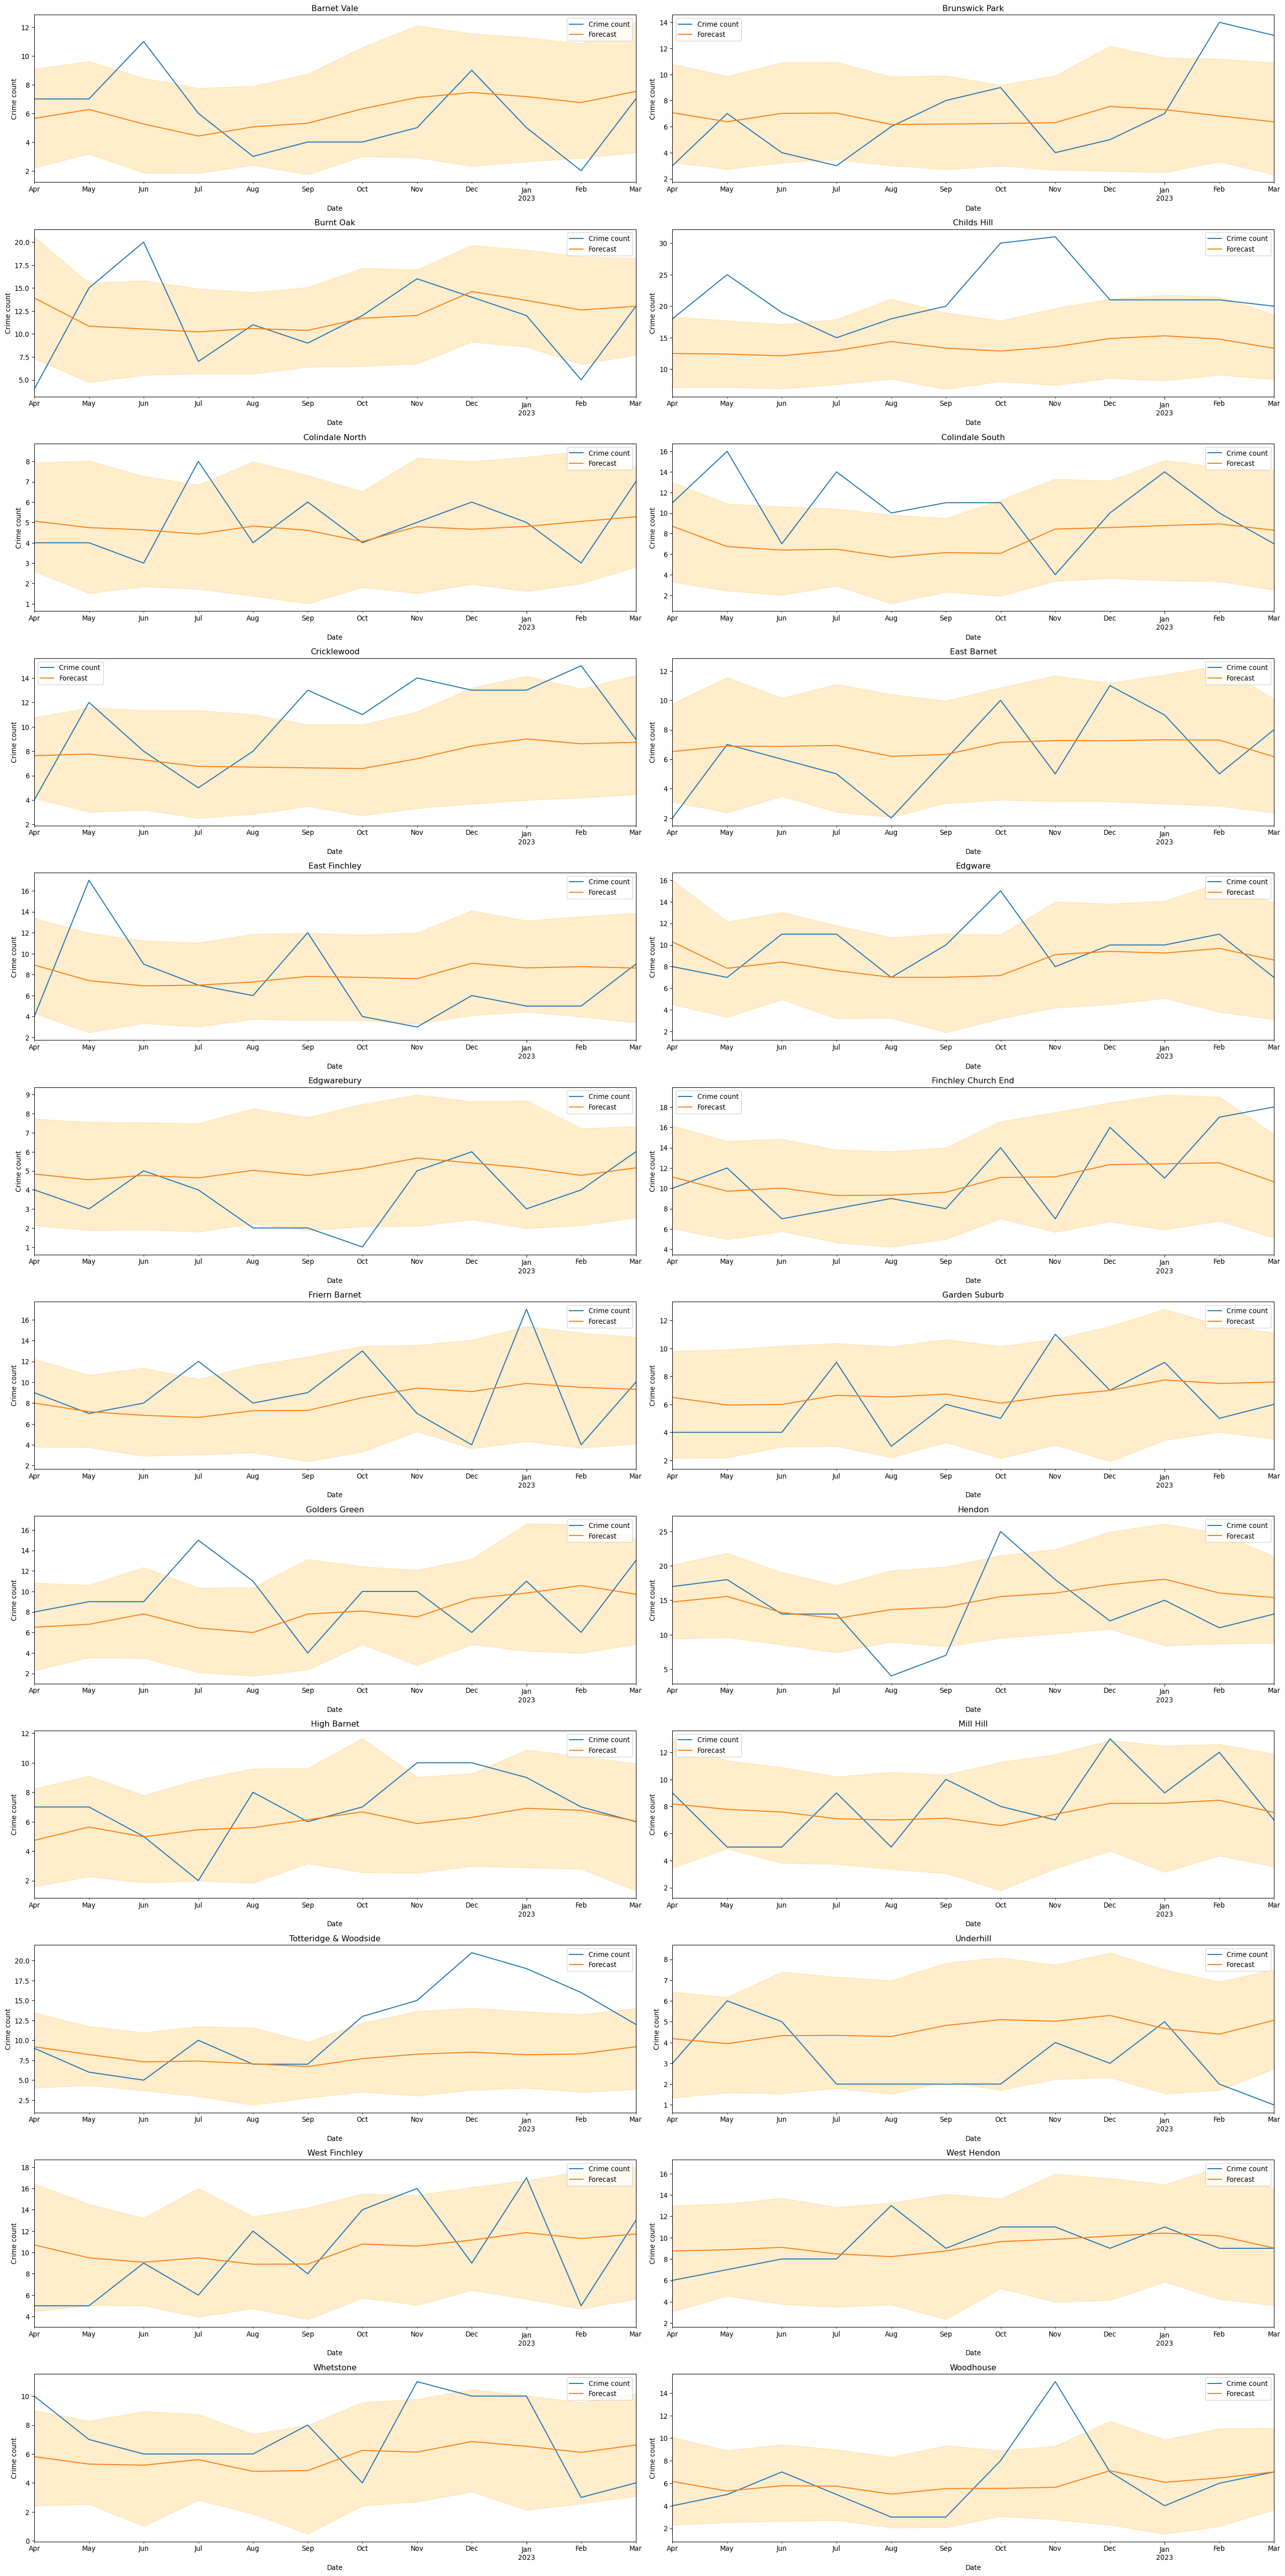

In [49]:
fig, ax = plt.subplots(12,2, figsize=(2*1280/96, 4*1280/96), dpi=96)
ax = ax.flatten()

for ax_ ,ward in enumerate(all_preds['Ward'].unique()):
    p_ = all_preds.loc[all_preds['Ward'] == ward]
    p_.plot(x='timestamp', y='crime_count', ax=ax[ax_], label='Crime count')
    p_.plot(x='timestamp', y='pred', ax=ax[ax_], label='Forecast')
    ax[ax_].fill_between(p_['timestamp'].values, p_['p10'], p_['p90'], alpha=0.2, color='orange')
    ax[ax_].set_title(ward)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Crime count')
    
fig.tight_layout()